In [1]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

import mbrl.models as models
import mbrl.replay_buffer as replay_buffer

device = torch.device("cuda:0")

%load_ext autoreload
%autoreload 2

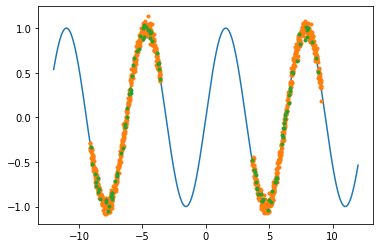

In [15]:
x_data = np.linspace(-12, 12, 10000)
y_data = np.sin(x_data)

train_val_size = 1100
train_size = 1000
train_val_idx = np.random.choice(list(range(1200, 3500)) + list(range(6500, 8800)), size=train_val_size, replace=False)
x_train = x_data[train_val_idx[:train_size]]
y_train = y_data[train_val_idx[:train_size]] + 0.05 * np.random.randn(train_size)
x_val = x_data[train_val_idx[train_size:]]
y_val = y_data[train_val_idx[train_size:]] + 0.05 * np.random.randn(train_val_size - train_size)

plt.plot(x_data, y_data, x_train, y_train, '.', x_val, y_val, '.')
plt.show()

In [16]:
num_members = 5
dataset_train = replay_buffer.BootstrapReplayBuffer(train_size, 256, num_members, (1,), (0,))
for i in range(train_size):
    dataset_train.add(x_train[i], 0, y_train[i], 0, False)

In [17]:
dataset_val = replay_buffer.IterableReplayBuffer(train_val_size - train_size, 256, (1,), (0,))
for i in range(train_val_size - train_size):
    dataset_val.add(x_val[i], 0, y_val[i], 0, False)

In [21]:
num_members = 5
ensemble = models.Ensemble(models.GaussianMLP, num_members, device, 1, 2, optim_lr=0.005, num_layers=2, hid_size=10)

best_weights found at epoch 0. Val loss:  0.284
best_weights found at epoch 1. Val loss:  0.275
best_weights found at epoch 2. Val loss:  0.264
best_weights found at epoch 3. Val loss:  0.256
best_weights found at epoch 4. Val loss:  0.251
best_weights found at epoch 5. Val loss:  0.249
best_weights found at epoch 8. Val loss:  0.249
best_weights found at epoch 11. Val loss:  0.248
best_weights found at epoch 12. Val loss:  0.239
best_weights found at epoch 13. Val loss:  0.239
best_weights found at epoch 16. Val loss:  0.237
best_weights found at epoch 17. Val loss:  0.237
best_weights found at epoch 18. Val loss:  0.237
best_weights found at epoch 19. Val loss:  0.234
best_weights found at epoch 23. Val loss:  0.233
best_weights found at epoch 24. Val loss:  0.231
best_weights found at epoch 28. Val loss:  0.227
best_weights found at epoch 29. Val loss:  0.225
best_weights found at epoch 35. Val loss:  0.222
best_weights found at epoch 37. Val loss:  0.219
best_weights found at epoch

best_weights found at epoch 340. Val loss:  0.050
best_weights found at epoch 341. Val loss:  0.049
best_weights found at epoch 344. Val loss:  0.049
best_weights found at epoch 346. Val loss:  0.048
best_weights found at epoch 347. Val loss:  0.047
best_weights found at epoch 351. Val loss:  0.047
best_weights found at epoch 352. Val loss:  0.046
best_weights found at epoch 356. Val loss:  0.045
best_weights found at epoch 357. Val loss:  0.045
best_weights found at epoch 360. Val loss:  0.045
best_weights found at epoch 362. Val loss:  0.044
best_weights found at epoch 366. Val loss:  0.044
best_weights found at epoch 369. Val loss:  0.044
best_weights found at epoch 371. Val loss:  0.043
best_weights found at epoch 376. Val loss:  0.043
best_weights found at epoch 377. Val loss:  0.043
best_weights found at epoch 383. Val loss:  0.042
best_weights found at epoch 384. Val loss:  0.042
best_weights found at epoch 390. Val loss:  0.041
best_weights found at epoch 392. Val loss:  0.041


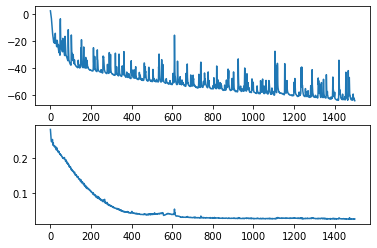

In [22]:
train_losses, val_losses = models.train_dyn_ensemble(
    ensemble, dataset_train, device, dataset_val=dataset_val, num_epochs=1500, patience=1500)
fig, ax = plt.subplots(2, 1)
ax[0].plot(train_losses)
ax[1].plot(val_losses)
plt.show()

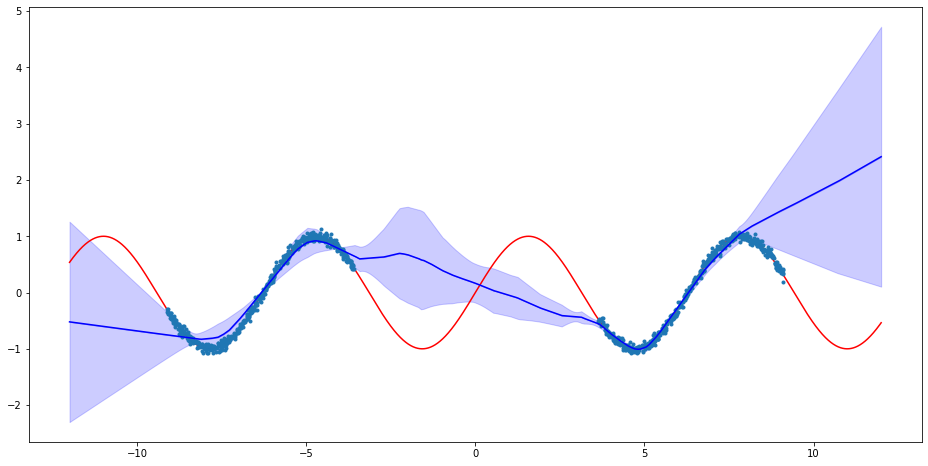

In [23]:
x_tensor = torch.from_numpy(x_data).unsqueeze(1).float().to(device)

y_mean = np.zeros_like(y_data)
for i in range(num_members):
    net, _ = ensemble[i]
    pred = net(x_tensor)
    y_pred = pred[0][:, 0].squeeze().detach().cpu().numpy()
    y_mean += y_pred
y_mean /= num_members

y_std = np.zeros_like(y_data)
for i in range(num_members):
    net, _ = ensemble[i]
    pred = net(x_tensor)
    y_pred = pred[0][:, 0].squeeze().detach().cpu().numpy()
    y_std += (y_pred - y_mean) ** 2
y_std /= (num_members - 1)
y_std = np.sqrt(y_std)
    
plt.figure(figsize=(16, 8))
plt.plot(x_data, y_data, 'r', x_train, y_train, '.', x_data, y_mean, 'b-')
plt.fill_between(x_data, y_mean, y_mean + y_std, color='b', alpha=0.2)
plt.fill_between(x_data, y_mean - y_std, y_mean, color='b', alpha=0.2)
plt.show()